## Import Libraries
<br> We will start by importing the Python libraries we will be using in this analysis. These libraries include:
<ul>
<li><b>pandas</b> and <b>numpy</b> for data ingestion and manipulation.</li>
<li>specific methods from <b>sklearn</b> for Machine Learning and 
<li><b>seed</b>, for reproducible result</li>

</ul>


In [1]:
import warnings
warnings.filterwarnings('ignore')

import os, re

import pandas as pd  # dataframes
import numpy as np

#for reading in test and image for visualizations
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn.feature_extraction.text import TfidfVectorizer
from lightgbm import LGBMClassifier

np.random.seed(234)

## Import data
<br> Using pandas read_csv, we read in our data. The train file have been cleaned. Thanks to Pawel Morawieki for the script. The notebook used to generate the clean text file is the zip file.
<ul>
<li> The first five rows of our dataframes were examnined using the head function</li>
</ul>


In [2]:
#import train and test data
train = pd.read_csv("train_clean.csv")
test = pd.read_csv("Devex_test_questions.csv",encoding = "ISO-8859-1")
sub = pd.read_csv("Devex_submission_format.csv")

In [3]:
sub.head()

,ID,3.1.1,3.1.2,3.2.1,3.2.2,3.3.1,3.3.2,3.3.3,3.3.4,3.3.5,...,3.8.2,3.9.1,3.9.2,3.9.3,3.a.1,3.b.1,3.b.2,3.b.3,3.c.1,3.d.1
0,11437,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
1,11474,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
2,11475,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
3,11476,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
4,11486,1.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0


In [4]:
test.head()

,Unique ID,Type,Text
0,49848,Organization,4th Sector Health: <p>4th Sector Health is a U...
1,52348,Organization,Action for Global Health: <p>Action for Global...
2,103541,Organization,Scottish Association for Mental Health (SAMH):...
3,52382,Organization,Singapore Immunology Network: <p>The Singapore...
4,47212,Organization,Coastal Conservation and Education Foundation ...


In [5]:
train.head()

,Unique ID,Type,Text,3.1.1,3.1.2,3.2.1,3.2.2,3.3.1,3.3.2,3.3.3,...,3.8.2,3.9.1,3.9.2,3.9.3,3.a.1,3.b.1,3.b.2,3.b.3,3.c.1,3.d.1
0,12555.0,Grant,Centers of Biomedical Research Excellence (COB...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
1,14108.0,Grant,Research on Regenerative Medicine Introduction...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,23168.0,Organization,Catholic Health Association of India (CHAI): T...,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,1
3,219512.0,Contract,Quality Improvement Initiatives for Diabetes,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,274093.0,Tender,Provision of Thalassemia Drugs and Disposables...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
len(train)

2995

<h1 style="font-size:2em;color:#2467C0">Data Cleaning</h1>
<ul>
<li> Remove the html tags </li>
<li> Remove symbols</li>
<li> This is done only on the test set. The same process was used to clean the train set</li>

In [7]:
cleanr = re.compile('<.*?>')

def remove_html(raw_html):
    cleantext = re.sub(cleanr, '', raw_html)
    cleantext = re.sub('&nbsp;', ' ', cleantext)
    cleantext = re.sub('&bull;', ' ', cleantext)
    return cleantext

In [8]:
for i in range(len(test)):
    test.at[i,'Text'] = remove_html(test.at[i,'Text'])

In [9]:
test = test.replace({r'\x0D': ' '}, regex=True) #removing carriage returns

<h1 style="font-size:2em;color:#2467C0">Visualization</h1>
<ul>
<li> Simple visualization of our train and test text data using word cloud</li>
</ul>

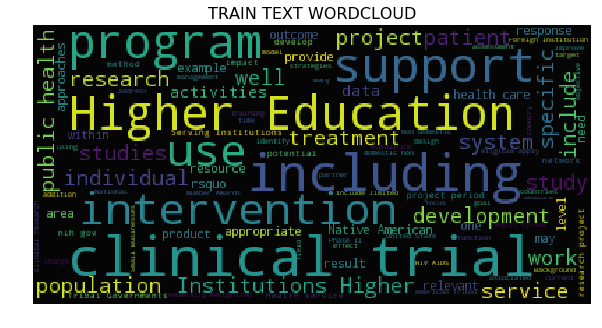

In [10]:
plt.figure(figsize=(10,8))
wc = WordCloud(background_color="black", max_words=100, 
            stopwords=STOPWORDS, max_font_size= 40)
wc.generate("".join(train['Text'].values))
plt.title('TRAIN TEXT WORDCLOUD', fontsize=16)
plt.imshow(wc.recolor(), alpha=0.98)
plt.axis('off')
plt.show()

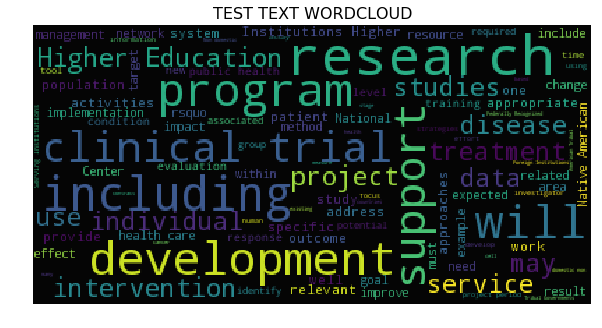

In [11]:
plt.figure(figsize=(10,8))
wc = WordCloud(background_color="black", max_words=100, 
            stopwords=STOPWORDS, max_font_size= 40)
wc.generate("".join(test['Text'].values))
plt.title('TEST TEXT WORDCLOUD', fontsize=16)
plt.imshow(wc.recolor(), alpha=0.98)
plt.axis('off')
plt.show()

<h1 style="font-size:2em;color:#2467C0">Feature Extraction</h1>
<ul>
<li> We will be training our model on the "Text" column of our dataframe. </li>
<li> However the raw data, a sequence of symbols cannot be fed directly to the algorithms themselves as most of them expect numerical feature vectors with a fixed size rather than the raw text documents with variable length.</li>
<li> Sklearn feature_extraction module deals with feature extraction from raw data. We will use it to extract features from the text column</li>
<li> TfidVectorizer convert our text to a matrix of TF-IDF features.</li>
<li> The next sets of cells initializes TfidVectorizer, we fit it on our train features, after which we transformed the text features of both the train and test data</li>

In [12]:
X_train = train['Text']
X_test = test['Text']

In [11]:
word =  TfidfVectorizer(ngram_range=(1,3), analyzer='word', norm='l2', stop_words='english',
               min_df=5, max_df=0.8, strip_accents='unicode', use_idf=True,
               smooth_idf=True, sublinear_tf=1 )

In [12]:
train_1 = word.fit_transform(X_train)

In [13]:
test_1 = word.transform(X_test)

<h1 style="font-size:2em;color:#2467C0">Modeling and Predicting</h1>
<ul>
<li> The next set of cells builds our model. The classifier will be trained on the train data, then used to predict on the test set</li>
<li> In the next set of cells, we extract the labels (dependent variables)</li>
<li> K-Folds (5 folds) cross-validator was used. The data was split into 5 folds, train on 4 sets and applied
to held-out data for prediction</li>
<li> The class probabilities was predicted and the outcome saved into a csv file. The class probabilities will be used for ensembling of different models</li>

In [14]:
labels = train[train.columns[3:]]

In [15]:
lablist = train.columns[3:].tolist()

In [16]:
target = train[lablist]
tr_ids = train[['Unique ID']]

In [17]:
folds = 5
scores = []
scores_classes = np.zeros((len(labels), folds))


submission = pd.DataFrame.from_dict({'Unique ID': test['Unique ID']})


#train each label at a time

kfold = KFold(n_splits=folds, shuffle=True, random_state=1001)
for j, (label) in enumerate(labels):
    
    classifier = LGBMClassifier()
    
    avreal = target[label]
    lr_pred = []
    lr_fpred = []
    
    #create an array of zeros to save the prediction on the held out training set
    lr_avpred = np.zeros(train_1.shape[0])
    
    
    for i, (train_index, val_index) in enumerate(kfold.split(train_1, target[label].values)):
        X_train, X_val = train_1[train_index], train_1[val_index]          #split the train set
        y_train, y_val = target.loc[train_index], target.loc[val_index]    #split the label
        
        classifier.fit(X_train, y_train[label])
        
        scores_val = classifier.predict_proba(X_val)[:,1]    #predict label probability for validation set
        lr_avpred[val_index] = scores_val                    #store our class probability in the array created earlier
        lr_y_pred = classifier.predict_proba(test_1)[:,1]    # predict label probability of test set
        
        
        scores_classes[j][i] = roc_auc_score(y_val[label], scores_val)  #calculate our roc_auc score on held out set
        scores.append(scores_classes[j])
        
        print('\n Fold %02d class %s AUC: %.6f' % ((i+1), label, scores_classes[j][i]))
        
        # if first fold, test class probabilities is the predicted probabilities, otherwise, add the probabilities
        if i > 0:
            lr_fpred = lr_pred + lr_y_pred 
        else:
            lr_fpred = lr_y_pred
        
        lr_pred = lr_fpred
           
    print('\n Average class %s AUC:\t%.6f' % (label, np.mean(scores_classes[j])))
    
    # we find the average of our predicted probabilities for our test data. Save it in a csv file.
    # we also covert the probalities to integers and save as a csv file for submission.
    
    submission[label] = lr_pred / folds
    sub = np.around(submission.iloc[0:]).astype('int')
    
print('\n Overall AUC:\t%.6f' % (np.mean(scores)))
sub.to_csv('submissionlgb.csv', index=False)
submission.to_csv('submissionlgbp.csv', index=False)


 Fold 01 class 3.1.1 AUC: 0.923971

 Fold 02 class 3.1.1 AUC: 0.839040

 Fold 03 class 3.1.1 AUC: 0.884954

 Fold 04 class 3.1.1 AUC: 0.858773

 Fold 05 class 3.1.1 AUC: 0.902940

 Average class 3.1.1 AUC:	0.881936

 Fold 01 class 3.1.2 AUC: 0.885009

 Fold 02 class 3.1.2 AUC: 0.830285

 Fold 03 class 3.1.2 AUC: 0.671087

 Fold 04 class 3.1.2 AUC: 0.844125

 Fold 05 class 3.1.2 AUC: 0.731054

 Average class 3.1.2 AUC:	0.792312

 Fold 01 class 3.2.1 AUC: 0.945566

 Fold 02 class 3.2.1 AUC: 0.920686

 Fold 03 class 3.2.1 AUC: 0.948518

 Fold 04 class 3.2.1 AUC: 0.934324

 Fold 05 class 3.2.1 AUC: 0.959482

 Average class 3.2.1 AUC:	0.941715

 Fold 01 class 3.2.2 AUC: 0.891414

 Fold 02 class 3.2.2 AUC: 0.917319

 Fold 03 class 3.2.2 AUC: 0.857694

 Fold 04 class 3.2.2 AUC: 0.960784

 Fold 05 class 3.2.2 AUC: 0.906745

 Average class 3.2.2 AUC:	0.906791

 Fold 01 class 3.3.1 AUC: 0.965484

 Fold 02 class 3.3.1 AUC: 0.983807

 Fold 03 class 3.3.1 AUC: 0.983425

 Fold 04 class 3.3.1 AUC: 0